## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


In [3]:
def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    
    
    print('x',x)
    print(y)
    return np.concatenate((x, y))


def piecewise_linear_first_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = -2
    a3 = 3
    cp1 = 3
    cp2 = 6
    add_noise=None
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    
    return np.concatenate((x, y))


def piecewise_linear_second_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = 3
    cp2 = 6
    add_noise=None
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    
    return np.concatenate((x, y))


def piecewise_linear_third_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = thetas[4]
    cp2 = thetas[5]
    
    add_noise=None
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return np.concatenate((x, y))

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)

print(a1,b, a2,a3, cp1, cp2)
x,y = piecewise_linear(a1,b, a2,a3, cp1, cp2)

plt.plot(x,y)

-0.49599808103003085 4.644019377739719 4.5568913814572 -6.702184068914208 2.096050056234762 5.853152612068656
x [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 

ValueError: too many values to unpack (expected 2)

In [5]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    x = np.arange(0,10,0.005)

    x = torch.from_numpy(x)

    y = np.copy(y)
    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(7) * np.nan
        
        s[0] = np.float32(batch[0])
        s[1] = np.nanmin(batch[x<4])
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[5] = np.nanmin(batch[x>=5])
            s[6] = x[np.nanargmin(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [7]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

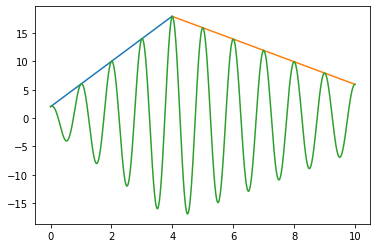

In [8]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [9]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    return_factors=False
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

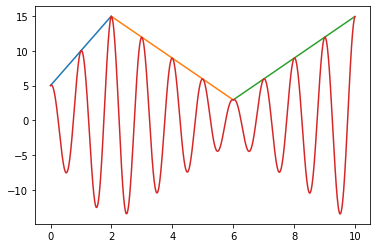

In [10]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

In [29]:
#parameter a1,b,a2,a3, cp1, cp2

prior_min = [3,3,-5,1,0,4]  

prior_max = [7, 7, -1, 3, 2, 6]



### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_first_batch, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=100,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
x_without

theta.shape

torch.Size([100, 2])

In [13]:
x = extract_sumstats(x_without)

In [14]:

inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 26 epochs.


In [15]:
true_params = [5, 5, -3, 2, 1, 5]


obs_real = piecewise_linear_first_batch(true_params[0:2])


obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([1, 7])


In [16]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:4], high = prior_max[2:4])


prior_combined =Combined(proposal1, prior2, number_params_1=2)


print('prior combined', prior_combined.sample((10,)).shape)
#print('prop',prior2.sample((10,)).shape)


inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_second_batch, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=100,
    num_workers=4,
)

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta pos size torch.Size([10, 2])
theta prior size torch.Size([10, 2])
2
theta tensor([[ 6.0185,  5.0340, -3.0402,  2.2594],
        [ 3.5747,  4.3859, -2.6851,  1.6865],
        [ 5.4469,  3.7455, -2.7356,  2.5140],
        [ 3.6921,  4.6350, -3.6716,  2.0373],
        [ 4.0998,  4.3156, -1.1469,  1.0707],
        [ 5.2451,  4.9920, -2.5133,  1.5645],
        [ 4.5610,  4.4338, -1.5823,  1.5136],
        [ 6.7963,  4.2499, -1.7863,  1.4075],
        [ 4.8081,  6.6193, -3.6926,  2.2181],
        [ 5.6732,  4.6036, -2.5606,  2.9201]])
prior combined torch.Size([10, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.7947,  3.3373, -2.6569,  2.9917]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 6.4287,  5.8682, -2.1491,  1.7333]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.4458,  3.5563, -4.0028,  2.6877]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 3.9970,  4.9800, -4.0249,  1.7716]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.4734,  3.8518, -2.3161,  1.2070]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.8319,  4.6721, -2.6716,  2.2076]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 6.9679,  5.4954, -3.2657,  1.8012],
        [ 4.7658,  4.2168, -4.8431,  1.1462]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.8882,  4.7230, -2.4812,  1.3114]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 3.5294,  6.2414, -4.0765,  1.5747]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 6.9776,  6.6315, -3.3702,  1.7782]])


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

theta pos size torch.Size([100, 2])
theta prior size torch.Size([100, 2])
2
theta tensor([[ 4.9461,  3.9312, -3.3089,  1.5135],
        [ 4.6687,  4.7604, -4.3476,  2.2538],
        [ 6.2218,  5.4834, -2.6619,  2.3857],
        [ 6.8352,  4.3354, -3.9973,  1.4510],
        [ 6.1251,  5.9598, -2.2133,  2.6146],
        [ 6.3680,  5.3517, -4.3136,  2.6139],
        [ 5.2912,  4.6948, -4.4121,  1.6307],
        [ 6.6199,  4.5630, -3.8521,  1.6408],
        [ 5.7663,  5.1655, -2.1715,  1.3815],
        [ 4.8410,  6.5703, -4.8108,  1.9687],
        [ 4.2627,  3.8385, -4.7245,  2.8196],
        [ 6.9311,  4.0466, -3.7122,  2.2794],
        [ 4.8748,  6.6146, -1.1148,  1.2784],
        [ 3.4208,  4.6720, -4.9218,  1.1022],
        [ 5.2029,  5.2643, -2.8267,  1.6200],
        [ 3.2481,  4.0655, -2.3343,  2.7951],
        [ 5.4685,  3.5234, -2.5252,  2.2277],
        [ 4.1624,  6.2164, -2.7116,  2.2627],
        [ 4.9105,  4.6922, -4.9072,  2.8490],
        [ 5.3754,  4.0427, -3.8162,  1.3760]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
x = extract_sumstats(x_without)


print(theta.shape)

inf = inf.append_simulations(theta, x)

print(inf)
density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

torch.Size([100, 4])
Neural network successfully converged after 145 epochs.


In [26]:

obs_real_stats = extract_sumstats([obs_real])

print(theta.shape)


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

torch.Size([100, 4])


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([-4.3452])


IndexError: The shape of the mask [1] at index 0 does not match the shape of the indexed tensor [100, 4] at index 0